# How to run QAOA with a custom cost function

The end-to-end QAOA example for Max-cut shows how to use the `Sampler` primitive to build a simple QAOA cost function.
This notebook shows how this cost function can be customized, for example, to use CVaR aggregation.

## 1. Implement custom cost function

In [1]:
def aggregate(alpha, measurements):

    if not 0 <= alpha <= 1:
        raise ValueError(f"alpha must be in [0, 1] but was {alpha}")

    # sort by values
    sorted_measurements = sorted(measurements, key=lambda x: x[1])
    accumulated_percent = 0.0  # once alpha is reached, stop
    cvar = 0.0
    for probability, value in sorted_measurements:
        cvar += value * min(probability, alpha - accumulated_percent)
        accumulated_percent += probability
        if accumulated_percent >= alpha:
            break

    return cvar / alpha

In [2]:
from qopt_best_practices.cost_function import evaluate_sparse_pauli

def cost_func_cvar_sampler(params, ansatz, hamiltonian, sampler, aggregation):

    job = sampler.run(ansatz, params)
    sampler_result = job.result()
    sampled = sampler_result.quasi_dists[0]

    # a dictionary containing: {state: (measurement probability, value)}
    evaluated = {
        state: (probability, evaluate_sparse_pauli(state, hamiltonian))
        for state, probability in sampled.items()
    }

    result = aggregate(aggregation, evaluated.values())

    return result

## 2. Define backend, initial point, hamiltonian, ansatz

Note that for simplicity, and to keep the focus on the cost function, this section of the workflow is NOT OPTIMIZED TO RUN ON HARDWARE, this is just a plain QAOA workflow and the selected backend is a statevector simulator. Please refer to the end-to-end tutorial for the hardware optimized version.

In [3]:
# BASIC STATEVECTOR SIMULATOR BACKEND --> primitives in qiskit.primtives

from qiskit.primitives import Sampler
sampler = Sampler()

In [5]:
# Import pre-computed Hamiltonian
import json
from qiskit.quantum_info import SparsePauliOp

graph_file = "../data/graph_2layers_0seed.json"
data = json.load(open(graph_file, "r"))
hamiltonian = SparsePauliOp.from_list(data["paulis"])
print(hamiltonian)

SparsePauliOp(['IIIIIZZIII', 'IIIIIIZIZI', 'IIIIIIZIIZ', 'ZIIIIZIIII', 'IIIIZZIIII', 'IIZIIIIZII', 'IZZIIIIIII', 'IIZZIIIIII', 'IIIIIIIZZI', 'IIIIZIIZII', 'IIIIZIIIIZ', 'IIIIIIIIZZ', 'ZZIIIIIIII', 'IZIZIIIIII', 'ZIIZIIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [6]:
# Build basic ansatz using the circuit library utility
from qiskit.circuit.library import QAOAAnsatz

ansatz = QAOAAnsatz(hamiltonian, reps=2)
ansatz.draw('mpl')
ansatz.measure_all()

In [4]:
# Define random initial point
import numpy as np

init_params = np.random.rand(ansatz.num_parameters)
print(init_params)

[0.8125 0.4375 0.1875 0.5625]


## 3. Run optimization

The only difference with the end-to-end workflow is that we now provide the desired aggregation value as an argument to the cost function.


In [8]:
from scipy.optimize import minimize

result = minimize(
    cost_func_cvar_sampler,
    init_params,
    args=(ansatz, hamiltonian, sampler, 0.5),
    method="COBYLA",
)
print(result)

/opt/anaconda3/envs/new-tutorials/lib/python3.9/site-packages/scipy/optimize/_cobyla_py.py:285: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,


 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -7.84765625
       x: [ 1.966e+00  7.869e-01  1.130e+00  1.780e+00]
    nfev: 52
   maxcv: 0.0


## 4. Sample and plot results

Identical to end-to-end workflow.

[1 1 1 1 1 0 0 0 1 1]


/var/folders/wy/lry0jnrs2h30d7hgtthkmpwc0000gn/T/ipykernel_40616/3512005436.py:2: DeprecationWarning: Insufficient bit width provided. This behavior will raise an error in the future.
  result = np.binary_repr(n, width=L)


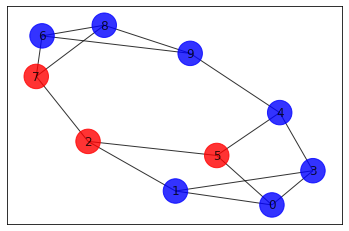

In [11]:
def bitfield(n, L):
    result = np.binary_repr(n, width=L)
    return [int(digit) for digit in result]

def sample_most_likely(state_vector):
    values = list(state_vector.values())
    n = int(np.log2(len(values)))
    k = np.argmax(np.abs(values))
    x = bitfield(k, n)
    x.reverse()
    return np.asarray(x)

qc = ansatz.assign_parameters(result.x)
samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]

best_result = sample_most_likely(samp_dist)
print(best_result)

import matplotlib.pyplot as plt
import networkx as nx
from qopt_best_practices.utils import build_max_cut_graph

# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ['r' if i == 0 else 'b' for i in x]
    pos, default_axes = nx.spring_layout(G), plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)

plot_result(build_max_cut_graph(data["paulis"]), best_result)
